# Assignment2, CMPT826

* Seyedeh Mina Mousavifar
* 11279515
* sem311

##  STEP 1: Preparation

### Data Collection

In [2]:
import pandas as pd
import sqlalchemy as db

engine = db.create_engine('mysql://sem311:p^HA89/h@crepe.usask.ca:3306/SHED10')

connection = engine.connect()
metadata = db.MetaData()

# Equivalent to 'SELECT * FROM battery
battery = db.Table('battery', metadata, autoload=True, autoload_with=engine)
query = db.select([battery])

# getting data by executing the query above
BatteryResultProxy = connection.execute(query)
BatteryResultSet = BatteryResultProxy.fetchall()

# converting data to data frame
battery_data = pd.DataFrame(BatteryResultSet)
battery_data.columns = BatteryResultSet[0].keys()

# removing index column from data - 0 for rows and 1 for column
battery_data = battery_data.drop('index', 1)

# Equivalent to 'SELECT * FROM gps
gps = db.Table('gps', metadata, autoload=True, autoload_with=engine)
query = db.select([gps])

# getting data by executing the query above
GPSResultProxy = connection.execute(query)
GPSResultSet = GPSResultProxy.fetchall()

# converting data to data frame
gps_data = pd.DataFrame(GPSResultSet)
gps_data.columns = GPSResultSet[0].keys()

# removing index column from data - 0 for rows and 1 for column
gps_data = gps_data.drop('index', 1)

print('fetching data completed')

fetching data completed


### Filtering Data

In [3]:
# counting number of battery information per user
battery_info = battery_data.groupby(['user_id']).size().reset_index(name='record_count')

# calculating filtering cutoff
cutoff_percentage = 0.5
max_battery_info = (60 / 5) * 24 * 30
battery_cutoff = cutoff_percentage * max_battery_info

# filtering users with less than 50%
battery_info_50 = battery_info.loc[battery_info['record_count'] > battery_cutoff]
users_filter_50, _ = battery_info_50.shape

# preserving only users with more than 50% battery record
user_battery = pd.merge(left=battery_data, right=battery_info_50, 
                           left_on='user_id', right_on='user_id')

# filtering accuracy more than 100
gps_data = gps_data.loc[gps_data['accu'] < 100]

# outside latitude range
gps_data = gps_data.loc[gps_data['lat'] > 52.058366]
gps_data = gps_data.loc[gps_data['lat'] < 52.214609]

# outside longitude range
gps_data = gps_data[gps_data['lon'] > -106.7649138128]
gps_data = gps_data.loc[gps_data['lon'] < -106.52225319]

# creating dataframe for filtering Saskatoon data for preferred users
good_50_user_id = user_battery.user_id.unique()
gps_data = gps_data[gps_data.user_id.isin(good_50_user_id)]

### Stratify and Aggregate

In [4]:
import datetime
import math
from pyproj import Proj
import numpy as np

# removing unnecessary columns
gps_data = gps_data.drop(['accu', 'alt', 
                          'bearing', 'speed', 
                          'record_time_minute', 
                          'timestamp', 'pokemon'], 1)

# calculating mean of latitude and longitude for every duty cycle
gps_data = gps_data.astype({'lat': 'float64', 'lon': 'float64'})

# sorting based on time 
gps_data = gps_data.sort_values(['user_id', 'record_time'])

# removing December test data
gps_data['Date'] = pd.to_datetime(gps_data['record_time']).dt.date
testdate = datetime.datetime.strptime('2016-12-09', "%Y-%m-%d").date()
gps_data = gps_data[(gps_data['Date'] > testdate)].dropna().reset_index()
gps_data = gps_data.drop(['Date', 'index'],1)


# extract duty cycles and calculate mean of latitude and longitude
gps_data = gps_data.groupby('user_id').resample('5T', on='record_time').mean()
gps_data = gps_data.drop(['user_id'],1).reset_index()

# converting to UTM
myproj = Proj('epsg:32613', proj='utm', zone=13, 
              ellps='WGS84', preserve_units=True)

gps_data['x'], gps_data['y'] = myproj(gps_data['lon'].values, 
                                      gps_data['lat'].values)
# binning
GRID_SIZE = 100

# find grid start point
start_x, start_y = gps_data.x.min(), gps_data.y.min()

# labeling grids
gps_data['x_grid'] = np.ceil((gps_data['x'] - start_x)/GRID_SIZE)
gps_data['y_grid'] = np.ceil((gps_data['y'] - start_y)/GRID_SIZE)

# sort data
gps_data = gps_data.sort_values(['user_id', 'record_time']).dropna()

# creating grid cell labels (x,y)
gps_data = gps_data.astype({'x_grid': 'int32', 
                            'y_grid': 'int32'}).astype({'x_grid': 'str', 
                                                        'y_grid': 'str'})
gps_data['grid_label'] = gps_data['x_grid'] + ',' + gps_data['y_grid']
gps_data = gps_data.astype({'x_grid': 'int32', 'y_grid': 'int32'})

##  STEP 2: Trip Definition

### Operationalizing trips

For finding trips, first, I compare two consecutive rows for a user and discover whether it had changed its cell. Then, I gave id for these change cells to make them traceable as different trajectories. So, the stayed time in each cell can be calculated by grouping based on a specific user, grid and trajectory id. Afterwards, trips can be operationalized as staying in cells less than a certain threshold.

In [173]:
gps_data = pd.read_pickle('data/gps_info.pkl')

In [174]:
# change cell condition
gps_data['change_cell'] = np.where(gps_data['grid_label'] != gps_data['grid_label'].shift(1), 1, 0)
gps_data['change_cell'] = np.where(gps_data['user_id'] == gps_data['user_id'].shift(1), 
                                   gps_data['change_cell'], 0)

# change in a cell can be used as change id for showing user trajectory
gps_data['change_id'] = gps_data.groupby('user_id')['change_cell'].cumsum()

#### $N = 1$
This means that staying in a cell more than 1 duty cycle ends the trip and leaving the cell less than or equal to 1 duty cycle start a trip.

In [175]:
TRIP_N = 1

# calculating staying time in one cell during their change
gps_trip_1 = gps_data.groupby(['user_id', 
                            'grid_label', 
                            'change_id']).size().reset_index(name = 'stay_count')

gps_trip_1['is_dwell'] = np.where(gps_trip_1['stay_count'] > TRIP_N, 1, 0)

# sorting data based on time
gps_trip_1 = gps_trip_1.sort_values(['user_id', 'change_id'])
gps_trip_1 = gps_trip_1.reset_index().drop(['index'], 1)

# trips are calculated as time between dwells
gps_trip_1['trip_id'] = gps_trip_1.groupby('user_id')['is_dwell'].cumsum()

gps_trip_1.head(10)

,user_id,grid_label,change_id,stay_count,is_dwell,trip_id
0,514,"59,69",0,1,0,0
1,514,"59,70",1,1,0,0
2,514,"59,69",2,3,1,1
3,514,"59,70",3,1,0,1
4,514,"59,69",4,5,1,2
5,514,"59,70",5,4,1,3
6,514,"59,69",6,1,0,3
7,514,"59,70",7,1,0,3
8,514,"59,69",8,2,1,4
9,514,"59,70",9,1,0,4


#### Trip length
This is the number of different grids seen until dwelling.

In [176]:
# trip length
trip_info_1 = gps_trip_1.groupby(['user_id',
                              'trip_id']).size().reset_index(name = 'length')
trip_info_1.head(10)

,user_id,trip_id,length
0,514,0,2
1,514,1,2
2,514,2,1
3,514,3,3
4,514,4,4
5,514,5,2
6,514,6,2
7,514,7,2
8,514,8,1
9,514,9,3


#### Number of Trips

In [177]:
trip_num_1 = trip_info_1.groupby('user_id').size().reset_index(name = 'count')
trip_num_1.head(10)

,user_id,count
0,514,814
1,534,197
2,551,717
3,555,409
4,559,307
5,767,130
6,793,228
7,933,315
8,942,196
9,943,208


#### Time of each trip

In this situation that $N=1$ the length of the trip is its time.

In [178]:
# Trip time
trip_info_1['time'] = trip_info_1['length']

trip_info_1.head(10)

,user_id,trip_id,length,time
0,514,0,2,2
1,514,1,2,2
2,514,2,1,1
3,514,3,3,3
4,514,4,4,4
5,514,5,2,2
6,514,6,2,2
7,514,7,2,2
8,514,8,1,1
9,514,9,3,3


#### $N = 3$
This means that staying in a cell more than 3 duty cycle ends the trip and leaving the cell less than or equal to 3 duty cycle start a trip.

In [179]:
TRIP_N = 3

# calculating staying time in one cell during their change
gps_trip_3 = gps_data.groupby(['user_id', 
                            'grid_label', 
                            'change_id']).size().reset_index(name = 'stay_count')

gps_trip_3['is_dwell'] = np.where(gps_trip_3['stay_count'] > TRIP_N, 1, 0)

# sorting data based on time
gps_trip_3 = gps_trip_3.sort_values(['user_id', 'change_id'])
gps_trip_3 = gps_trip_3.reset_index().drop(['index'], 1)

# trips are calculated as time between dwells
gps_trip_3['trip_id'] = gps_trip_3.groupby('user_id')['is_dwell'].cumsum()

#### Trip length

In [180]:
# trip length
trip_info_3 = gps_trip_3.groupby(['user_id',
                              'trip_id']).size().reset_index(name = 'length')
trip_info_3.head(10)

,user_id,trip_id,length
0,514,0,4
1,514,1,1
2,514,2,11
3,514,3,2
4,514,4,12
5,514,5,2
6,514,6,2
7,514,7,2
8,514,8,5
9,514,9,9


#### Number of Trips

In [181]:
trip_num_3 = trip_info_3.groupby('user_id').size().reset_index(name = 'count')
trip_num_3.head(10)

,user_id,count
0,514,506
1,534,140
2,551,467
3,555,249
4,559,203
5,767,87
6,793,139
7,933,198
8,942,120
9,943,123


#### Time of each trip

In this situation that $N=3$, the sum of staying in each cell involved in the trip is the trip time.

In [182]:
# Trip time

# change dwellings that are more than threshold to 1 to 
# calculate them as just 1 duty cycle just as entering the cell
tmp_trip = gps_trip_3.copy(deep=True)
tmp_trip.loc[tmp_trip.stay_count > TRIP_N, 'stay_count'] = 1

trip_time_3 = tmp_trip.groupby(['user_id', 'trip_id']).agg(time = ('stay_count', 'sum'))
trip_time_3 = trip_time_3.reset_index()

# add it trip length to have full trip info
trip_info_3 = pd.merge(trip_info_3, trip_time_3, how='inner', on=['user_id', 'trip_id'])
trip_info_3.head(10)

,user_id,trip_id,length,time
0,514,0,4,6
1,514,1,1,1
2,514,2,11,15
3,514,3,2,2
4,514,4,12,17
5,514,5,2,2
6,514,6,2,3
7,514,7,2,2
8,514,8,5,6
9,514,9,9,13


#### $N = 5$
This means that staying in a cell more than 3 duty cycle ends the trip and leaving the cell less than or equal to 3 duty cycle start a trip.

In [183]:
TRIP_N = 5

# calculating staying time in one cell during their change
gps_trip_5 = gps_data.groupby(['user_id', 
                            'grid_label', 
                            'change_id']).size().reset_index(name = 'stay_count')

gps_trip_5['is_dwell'] = np.where(gps_trip_5['stay_count'] > TRIP_N, 1, 0)

# sorting data based on time
gps_trip_5 = gps_trip_5.sort_values(['user_id', 'change_id'])
gps_trip_5 = gps_trip_5.reset_index().drop(['index'], 1)

# trips are calculated as time between dwells
gps_trip_5['trip_id'] = gps_trip_5.groupby('user_id')['is_dwell'].cumsum()

#### Trip length

In [184]:
# trip length
trip_info_5 = gps_trip_5.groupby(['user_id',
                              'trip_id']).size().reset_index(name = 'length')
trip_info_5.head(10)

,user_id,trip_id,length
0,514,0,18
1,514,1,12
2,514,2,4
3,514,3,2
4,514,4,5
5,514,5,9
6,514,6,6
7,514,7,6
8,514,8,2
9,514,9,2


#### Number of Trips

In [185]:
trip_num_5 = trip_info_5.groupby('user_id').size().reset_index(name = 'count')
trip_num_5.head(10)

,user_id,count
0,514,333
1,534,123
2,551,353
3,555,180
4,559,165
5,767,83
6,793,113
7,933,151
8,942,90
9,943,92


#### Time of each trip

In this situation that $N=5$, the sum of staying in each cell involved in the trip is the trip time.

In [186]:
# Trip time

# change dwellings that are more than threshold to 1 to 
# calculate them as just 1 duty cycle just as entering the cell
tmp_trip = gps_trip_5.copy(deep=True)
tmp_trip.loc[tmp_trip.stay_count > TRIP_N, 'stay_count'] = 1

trip_time_5 = tmp_trip.groupby(['user_id', 'trip_id']).agg(time = ('stay_count', 'sum'))
trip_time_5 = trip_time_5.reset_index()

# add it trip length to have full trip info
trip_info_5 = pd.merge(trip_info_5, trip_time_5, how='inner', on=['user_id', 'trip_id'])
trip_info_5.head(10)

,user_id,trip_id,length,time
0,514,0,18,35
1,514,1,12,17
2,514,2,4,8
3,514,3,2,2
4,514,4,5,6
5,514,5,9,13
6,514,6,6,9
7,514,7,6,16
8,514,8,2,2
9,514,9,2,5


##  STEP 3: Presentation

### Distributions for trip number (over participants)

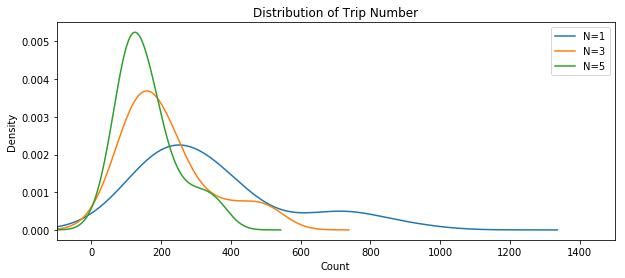

In [210]:
import matplotlib.pyplot as plt

# merging all trip counts for users for different N
trip_num = pd.merge(trip_num_1, trip_num_3, how='inner', on=['user_id'])
trip_num = pd.merge(trip_num, trip_num_5, how='inner', on=['user_id'])
trip_num = trip_num.drop(['user_id'], 1)
trip_num = trip_num.rename(columns={'count_x': 'N=1', 
                                    'count_y': 'N=3',
                                    'count': 'N=5'})

plot = trip_num.plot.kde(figsize=(10, 4),
                         bw_method=0.5)

plot = plot.set(xlabel='Count', 
                xlim= (-100,1500),
                title = 'Distribution of Trip Number')

### Distributions for trip length (over participant-trips)

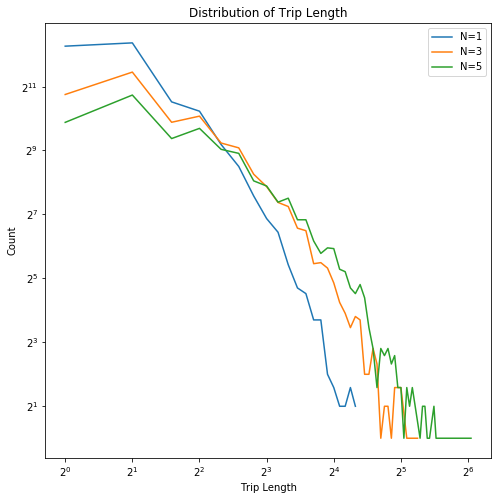

In [212]:
# set size of figure
plt.figure(figsize=(8, 8))
# set title
plt.title('Distribution of Trip Length')
plt.xlabel('Trip Length')
plt.ylabel('Count')

# calculate count of trip length
length_1 = trip_info_1.groupby(['length']).size().reset_index(name='count')
length_3 = trip_info_3.groupby(['length']).size().reset_index(name='count')
length_5 = trip_info_5.groupby(['length']).size().reset_index(name='count')

plt.plot(length_1['length'], length_1['count'], label='N=1')
plt.plot(length_3['length'], length_3['count'], label='N=3')
plt.plot(length_5['length'], length_5['count'], label='N=5')

plt.xscale('log', basex=2)
plt.yscale('log', basey=2)

plt.legend()

plt.show()

### Distributions for trip duration (over participant-trips)

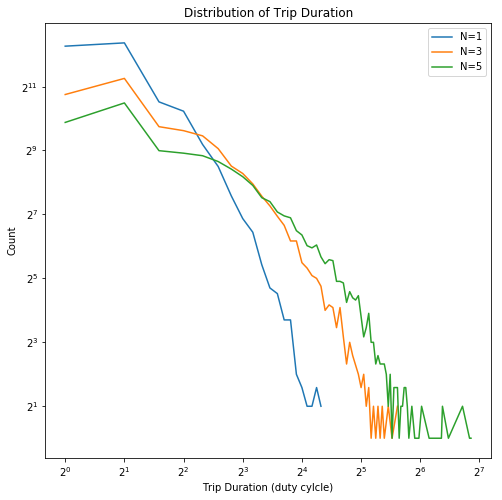

In [211]:
# set size of figure
plt.figure(figsize=(8, 8))
# set title
plt.title('Distribution of Trip Duration')
plt.xlabel('Trip Duration (duty cylcle)')
plt.ylabel('Count')

# calculate count of trip length
time_1 = trip_info_1.groupby(['time']).size().reset_index(name='count')
time_3 = trip_info_3.groupby(['time']).size().reset_index(name='count')
time_5 = trip_info_5.groupby(['time']).size().reset_index(name='count')

plt.plot(time_1['time'], time_1['count'], label='N=1')
plt.plot(time_3['time'], time_3['count'], label='N=3')
plt.plot(time_5['time'], time_5['count'], label='N=5')

plt.xscale('log', basex=2)
plt.yscale('log', basey=2)

plt.legend()

plt.show()

### Explain how you concluded which representation best fit the data.

> I used log-log because when I use linear axis, the curves had a steep fall. This plot didn't have much information, so after moving to log-log plot, we can see patterns in our data.

### Plot a heat map

#### Over all participants which includes only trips

$N=1$

In [229]:
import os
import folium
from folium.plugins import HeatMap

# change dwellings that are more than threshold to 1 to 
# calculate them as just 1 duty cycle just as entering the cell
TRIP_N = 1
trip = gps_trip_1.copy(deep=True)
trip.loc[trip.stay_count > TRIP_N, 'stay_count'] = 1

# converting grid label to x,y
trip[['x_grid','y_grid']] = trip.grid_label.str.split(",",expand=True)

# covert to float
trip = trip.astype({'x_grid': 'float64',
                    'y_grid': 'float64',
                    'stay_count': 'float64'})

# calculate center of grid to convert to latitude and longitude for heatmap plotting
trip['x_center'] = trip['x_grid']*GRID_SIZE - (0.5*GRID_SIZE) + start_x
trip['y_center'] = trip['y_grid']*GRID_SIZE - (0.5*GRID_SIZE) + start_y

# convert to latitude and longitude
myproj = Proj('epsg:32613', proj='utm', zone=13, ellps='WGS84', preserve_units=True)

trip['lon_center'], trip['lat_center'] = myproj(trip['x_center'].values, 
                                                trip['y_center'].values, 
                                                inverse=True)

# creating map
hmap_data = folium.Map(location=[52.058367, -106.7649138128])

# plotting map
hm_wide = HeatMap(list(zip(trip.lat_center.values, 
                           trip.lon_center.values)), 
                  radius=13)
    
# fit map zoom
hmap_data.fit_bounds([trip[['lat_center', 'lon_center']].min().values.tolist(),
                      trip[['lat_center', 'lon_center']].max().values.tolist()]) 

hmap_data.add_child(hm_wide)

# exporting map as html file
hmap_data.save(os.path.join('map', 'trip_1.html'))

# hmap_data

<img src='images/trip_1.png'>

$N=3$

In [230]:
# change dwellings that are more than threshold to 1 to 
# calculate them as just 1 duty cycle just as entering the cell
TRIP_N = 3
trip = gps_trip_3.copy(deep=True)
trip.loc[trip.stay_count > TRIP_N, 'stay_count'] = 1

# converting grid label to x,y
trip[['x_grid','y_grid']] = trip.grid_label.str.split(",",expand=True)

# covert to float
trip = trip.astype({'x_grid': 'float64',
                    'y_grid': 'float64',
                    'stay_count': 'float64'})

# calculate center of grid to convert to latitude and longitude for heatmap plotting
trip['x_center'] = trip['x_grid']*GRID_SIZE - (0.5*GRID_SIZE) + start_x
trip['y_center'] = trip['y_grid']*GRID_SIZE - (0.5*GRID_SIZE) + start_y

# convert to latitude and longitude
myproj = Proj('epsg:32613', proj='utm', zone=13, ellps='WGS84', preserve_units=True)

trip['lon_center'], trip['lat_center'] = myproj(trip['x_center'].values, 
                                                trip['y_center'].values, 
                                                inverse=True)

# creating map
hmap_data = folium.Map(location=[52.058367, -106.7649138128])

# plotting map
hm_wide = HeatMap(list(zip(trip.lat_center.values, 
                           trip.lon_center.values)), 
                  radius=13)
    
# fit map zoom
hmap_data.fit_bounds([trip[['lat_center', 'lon_center']].min().values.tolist(),
                      trip[['lat_center', 'lon_center']].max().values.tolist()]) 

hmap_data.add_child(hm_wide)

# exporting map as html file
hmap_data.save(os.path.join('map', 'trip_3.html'))

# hmap_data

<img src='images/trip_3.png'>

$N=5$

In [233]:
# change dwellings that are more than threshold to 1 to 
# calculate them as just 1 duty cycle just as entering the cell
TRIP_N = 5
trip = gps_trip_5.copy(deep=True)
trip.loc[trip.stay_count > TRIP_N, 'stay_count'] = 1

# converting grid label to x,y
trip[['x_grid','y_grid']] = trip.grid_label.str.split(",",expand=True)

# covert to float
trip = trip.astype({'x_grid': 'float64',
                    'y_grid': 'float64',
                    'stay_count': 'float64'})

# calculate center of grid to convert to latitude and longitude for heatmap plotting
trip['x_center'] = trip['x_grid']*GRID_SIZE - (0.5*GRID_SIZE) + start_x
trip['y_center'] = trip['y_grid']*GRID_SIZE - (0.5*GRID_SIZE) + start_y

# convert to latitude and longitude
myproj = Proj('epsg:32613', proj='utm', zone=13, ellps='WGS84', preserve_units=True)

trip['lon_center'], trip['lat_center'] = myproj(trip['x_center'].values, 
                                                trip['y_center'].values, 
                                                inverse=True)

# creating map
hmap_data = folium.Map(location=[52.058367, -106.7649138128])

# plotting map
hm_wide = HeatMap(list(zip(trip.lat_center.values, 
                           trip.lon_center.values)), 
                  radius=13)
    
# fit map zoom
hmap_data.fit_bounds([trip[['lat_center', 'lon_center']].min().values.tolist(),
                      trip[['lat_center', 'lon_center']].max().values.tolist()]) 

hmap_data.add_child(hm_wide)

# exporting map as html file
hmap_data.save(os.path.join('map', 'trip_5.html'))

# hmap_data

<img src='images/trip_5.png'>

#### Over all participants which includes only non-trips for each N

$N=1$

In [234]:
# change dwellings that are more than threshold to 1 to 
# calculate them as just 1 duty cycle just as entering the cell
TRIP_N = 1
non_trip = gps_trip_1.loc[gps_trip_1['stay_count'] >= TRIP_N]

# converting grid label to x,y
non_trip[['x_grid','y_grid']] = non_trip.grid_label.str.split(",",expand=True)

# covert to float
non_trip = non_trip.astype({'x_grid': 'float64',
                    'y_grid': 'float64',
                    'stay_count': 'float64'})

# calculate center of grid to convert to latitude and longitude for heatmap plotting
non_trip['x_center'] = non_trip['x_grid']*GRID_SIZE - (0.5*GRID_SIZE) + start_x
non_trip['y_center'] = non_trip['y_grid']*GRID_SIZE - (0.5*GRID_SIZE) + start_y

# convert to latitude and longitude
myproj = Proj('epsg:32613', proj='utm', zone=13, ellps='WGS84', preserve_units=True)

non_trip['lon_center'], non_trip['lat_center'] = myproj(non_trip['x_center'].values, 
                                                 non_trip['y_center'].values, 
                                                 inverse=True)

# creating map
hmap_data = folium.Map(location=[52.058367, -106.7649138128])

# plotting map
hm_wide = HeatMap(list(zip(trip.lat_center.values, 
                           trip.lon_center.values)), 
                  radius=13)
    
# fit map zoom
hmap_data.fit_bounds([trip[['lat_center', 'lon_center']].min().values.tolist(),
                      trip[['lat_center', 'lon_center']].max().values.tolist()]) 

hmap_data.add_child(hm_wide)

# exporting map as html file
hmap_data.save(os.path.join('map', 'nontrip_1.html'))

# hmap_data

<img src='images/nontrip_1.png'>

$N=3$

In [235]:
# change dwellings that are more than threshold to 1 to 
# calculate them as just 1 duty cycle just as entering the cell
TRIP_N = 1
non_trip = gps_trip_3.loc[gps_trip_3['stay_count'] >= TRIP_N]

# converting grid label to x,y
non_trip[['x_grid','y_grid']] = non_trip.grid_label.str.split(",",expand=True)

# covert to float
non_trip = non_trip.astype({'x_grid': 'float64',
                    'y_grid': 'float64',
                    'stay_count': 'float64'})

# calculate center of grid to convert to latitude and longitude for heatmap plotting
non_trip['x_center'] = non_trip['x_grid']*GRID_SIZE - (0.5*GRID_SIZE) + start_x
non_trip['y_center'] = non_trip['y_grid']*GRID_SIZE - (0.5*GRID_SIZE) + start_y

# convert to latitude and longitude
myproj = Proj('epsg:32613', proj='utm', zone=13, ellps='WGS84', preserve_units=True)

non_trip['lon_center'], non_trip['lat_center'] = myproj(non_trip['x_center'].values, 
                                                 non_trip['y_center'].values, 
                                                 inverse=True)

# creating map
hmap_data = folium.Map(location=[52.058367, -106.7649138128])

# plotting map
hm_wide = HeatMap(list(zip(trip.lat_center.values, 
                           trip.lon_center.values)), 
                  radius=13)
    
# fit map zoom
hmap_data.fit_bounds([trip[['lat_center', 'lon_center']].min().values.tolist(),
                      trip[['lat_center', 'lon_center']].max().values.tolist()]) 

hmap_data.add_child(hm_wide)

# exporting map as html file
hmap_data.save(os.path.join('map', 'nontrip_3.html'))

# hmap_data

<img src='images/nontrip_3.png'>

$N=5$

In [ ]:
# change dwellings that are more than threshold to 1 to 
# calculate them as just 1 duty cycle just as entering the cell
TRIP_N = 5
non_trip = gps_trip_5.loc[gps_trip_5['stay_count'] >= TRIP_N]

# converting grid label to x,y
non_trip[['x_grid','y_grid']] = non_trip.grid_label.str.split(",",expand=True)

# covert to float
non_trip = non_trip.astype({'x_grid': 'float64',
                    'y_grid': 'float64',
                    'stay_count': 'float64'})

# calculate center of grid to convert to latitude and longitude for heatmap plotting
non_trip['x_center'] = non_trip['x_grid']*GRID_SIZE - (0.5*GRID_SIZE) + start_x
non_trip['y_center'] = non_trip['y_grid']*GRID_SIZE - (0.5*GRID_SIZE) + start_y

# convert to latitude and longitude
myproj = Proj('epsg:32613', proj='utm', zone=13, ellps='WGS84', preserve_units=True)

non_trip['lon_center'], non_trip['lat_center'] = myproj(non_trip['x_center'].values, 
                                                 non_trip['y_center'].values, 
                                                 inverse=True)

# creating map
hmap_data = folium.Map(location=[52.058367, -106.7649138128])

# plotting map
hm_wide = HeatMap(list(zip(trip.lat_center.values, 
                           trip.lon_center.values)), 
                  radius=13)
    
# fit map zoom
hmap_data.fit_bounds([trip[['lat_center', 'lon_center']].min().values.tolist(),
                      trip[['lat_center', 'lon_center']].max().values.tolist()]) 

hmap_data.add_child(hm_wide)

# exporting map as html file
hmap_data.save(os.path.join('map', 'nontrip_5.html'))

# hmap_data

<img src='images/nontrip_5.png'>

##  STEP 4: Interpretation

4.1 What is the impact of changing N on the distribution of trip number, length and duration? What trips are being captured and which are being ignored? Given an example of a research question where the differences would be important, and an example of a question where they would be unimportant.

> b

4.2 What distinguishing features did you see in the heatmaps? Where there points included in either map (trip, not trip) at any N that seemed out of place? How would you change the operationalization to eliminate these points?

> b